In [1]:
import numpy as np
import pyproj
import glob
import datetime
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
np.float = float

In [2]:
figpath = '/Users/carmennab/Dropbox/michel_csao/figures/'

### load grid

In [5]:
def WGS84toEASE2(lon, lat):
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=-90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x , y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

file='/Users/carmennab/cpom_server//home/gch/SS_budget_23/grids_S/Pathfinder_gs_SH.npz'
npzfile =  np.load(file)
lon = npzfile["lons"]
lat = npzfile["lats"]
grid_x, grid_y = WGS84toEASE2(lon, lat)

In [6]:
datapath = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/2024-08-15/data_out_smoothed/'
files = sorted(glob.glob(datapath+'*.nc'))

In [7]:
all_budgets = [] 

for file in files:
    start_date_str = file.split('/')[9].split('_')[1].split('--')[0]
    start_date = datetime.datetime.strptime(start_date_str,"%Y%m%d").date()

    data = Dataset(file)

    intensification = np.array(data['intensification']) * 86400
    advection = np.array(data['advection']) * 86400
    divergence = np.array(data['divergence']) * 86400
    residual = np.array(data['residual']) * 86400
    ice_drift_x = np.array(data['ice_drift_x']) 
    ice_drift_y = np.array(data['ice_drift_y']) 

    b = {'year':start_date.year,'month':start_date.month,'intensification':intensification,
         'advection':advection,'divergence':divergence,'residual':residual,
         'ice_drift_x':ice_drift_x,'ice_drift_y':ice_drift_y}

    all_budgets.append(b)
    
### create dataframe of all budgets
all_budgets = pd.DataFrame(all_budgets).sort_values(['month','year'])

In [11]:
budget_terms = ['intensification','advection','divergence','residual','ice_drift_x',
                'ice_drift_y']

### plot climatology and average anomaly from climatology, for each month

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_5728/2743619929.py:9: RuntimeWarning: Mean of empty slice
  drift_mean_x = np.nanmean(np.array([data for data in month_data['ice_drift_x']]),axis=0)
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_5728/2743619929.py:10: RuntimeWarning: Mean of empty slice
  drift_mean_y = np.nanmean(np.array([data for data in month_data['ice_drift_y']]),axis=0)
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_5728/2743619929.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.array([data for data in month_data[term]]),axis=0)


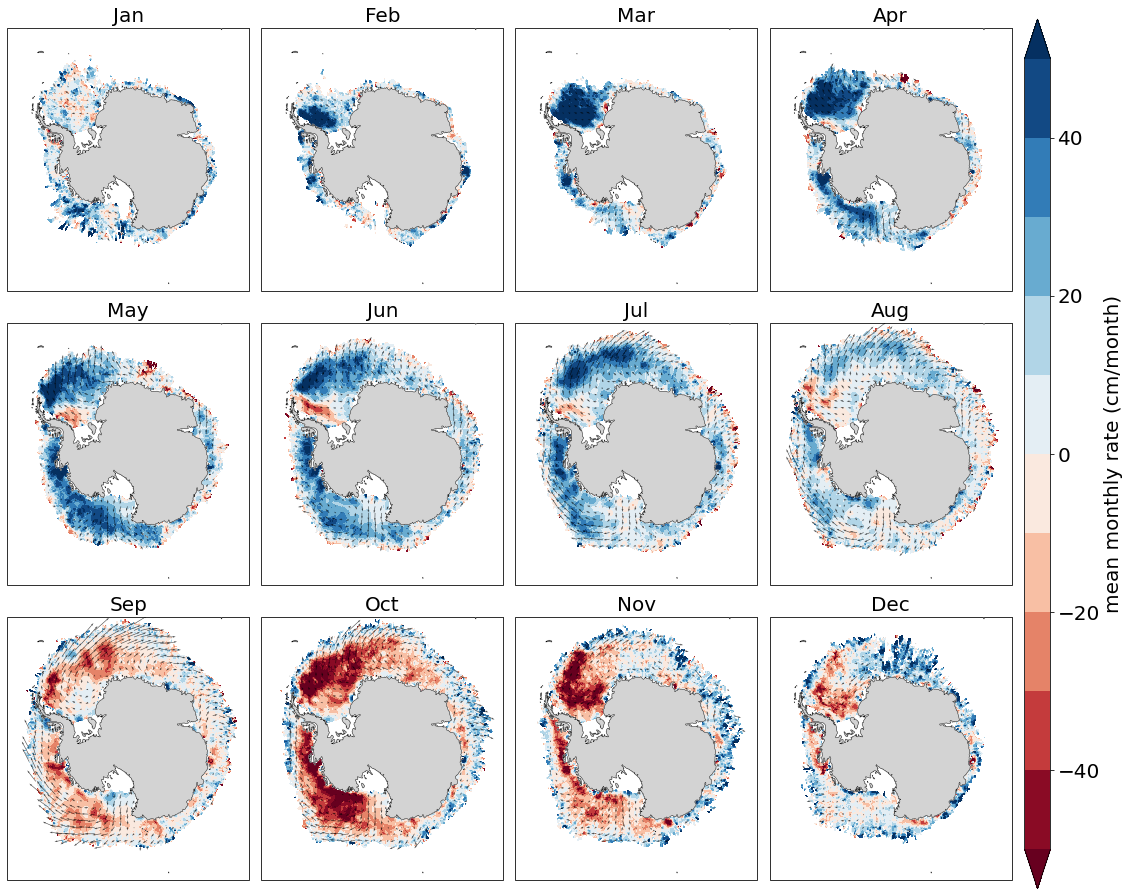

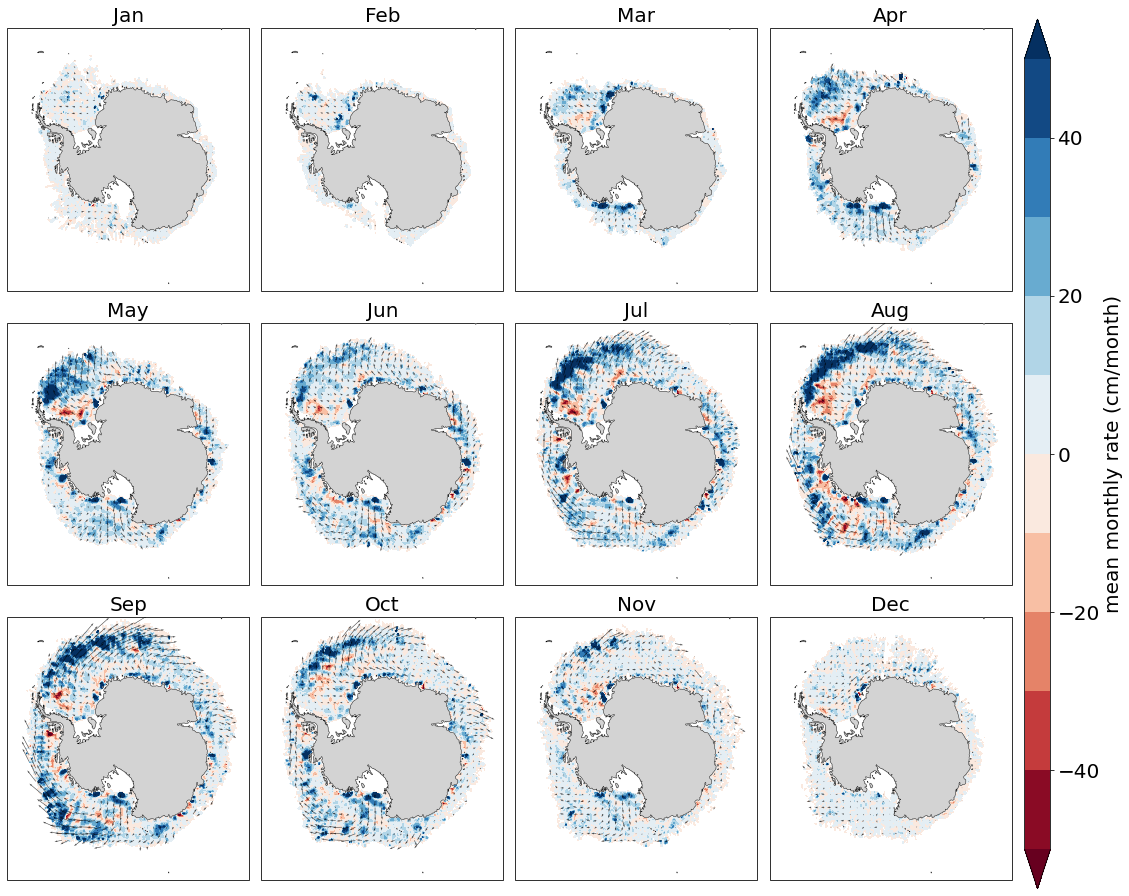

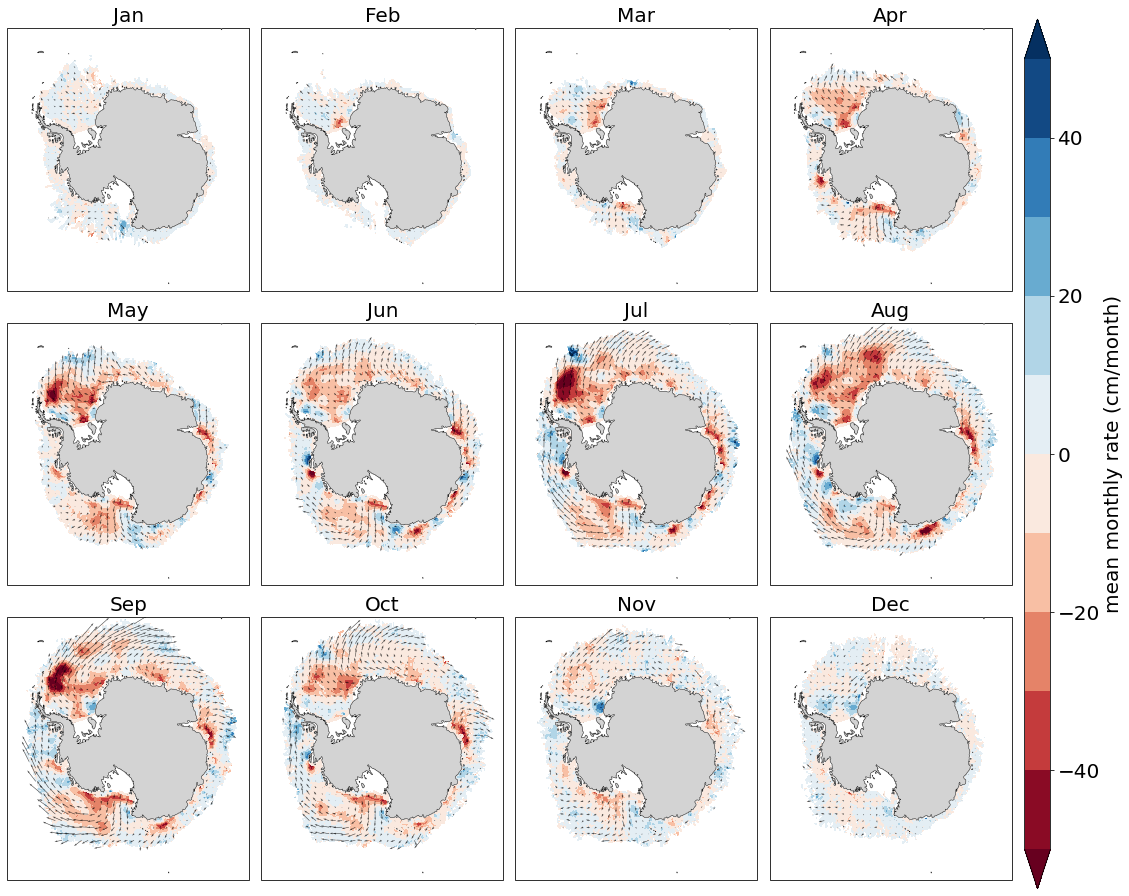

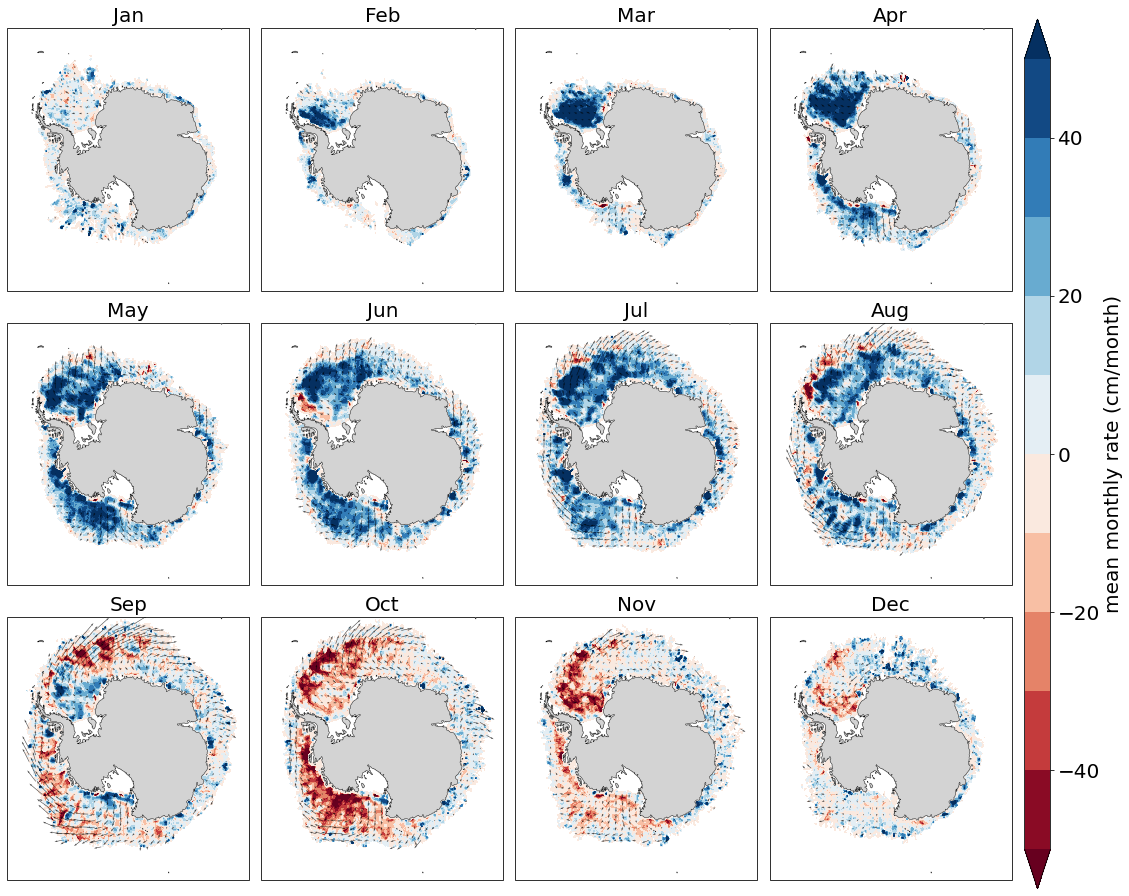

In [10]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for term in budget_terms[:4]:
    fig = plt.figure(figsize=(18,16))
    spec = gridspec.GridSpec(ncols=4, nrows=3, wspace=0.05,hspace=0.05)
    for count,month in enumerate(sorted(set(all_budgets['month']))):
        month_data = all_budgets[all_budgets['month']==month]
        
        drift_mean_x = np.nanmean(np.array([data for data in month_data['ice_drift_x']]),axis=0)
        drift_mean_y = np.nanmean(np.array([data for data in month_data['ice_drift_y']]),axis=0)
        mean = np.nanmean(np.array([data for data in month_data[term]]),axis=0)
        
        ax = fig.add_subplot(spec[count],projection=ccrs.SouthPolarStereo())
        ax.set_extent([-60, 180, -90, -55], ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, zorder=100,linewidth=0.4)
        ax.add_feature(cfeature.LAND, zorder=99, color='lightgray', edgecolor='black')
        cmap = ax.contourf(grid_x,grid_y,mean*100,cmap='RdBu',levels=np.arange(-50,55,10),extend='both')
        ax.quiver(grid_x[::8, ::8], grid_y[::8, ::8], drift_mean_x[::8, ::8],
                  drift_mean_y[::8, ::8], scale=2.7, color='black', alpha=0.7)
        
        if count == 2: 
            cbar_ax = fig.add_axes([0.91, 0.125, 0.02, 0.755]) # x, y, width, height
            a = fig.colorbar(cmap, cax=cbar_ax,extend='both',) 
            a.set_label('mean monthly rate (cm/month)',size=20)
            a.ax.tick_params(labelsize=20)

        ax.set_title(months[count],fontsize=20)
    plt.savefig(f'{figpath}budgets_{term}.jpg',bbox_inches = "tight", dpi = 400)